## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set04 test01 known vehicle, known attack)

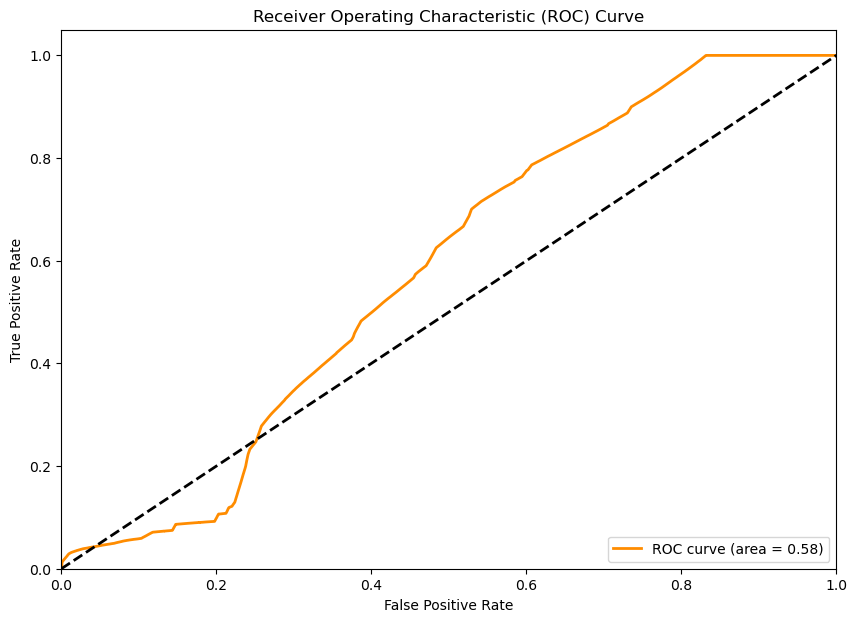

AUC: 0.5782
Accuracy: 0.6849
Precision: 0.9591
Recall: 0.6849
F1-score: 0.7946
Training Time: 18.0151 seconds
Testing Time: 0.7001 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81   6746071
           1       0.03      0.36      0.05    149948

    accuracy                           0.68   6896019
   macro avg       0.50      0.53      0.43   6896019
weighted avg       0.96      0.68      0.79   6896019



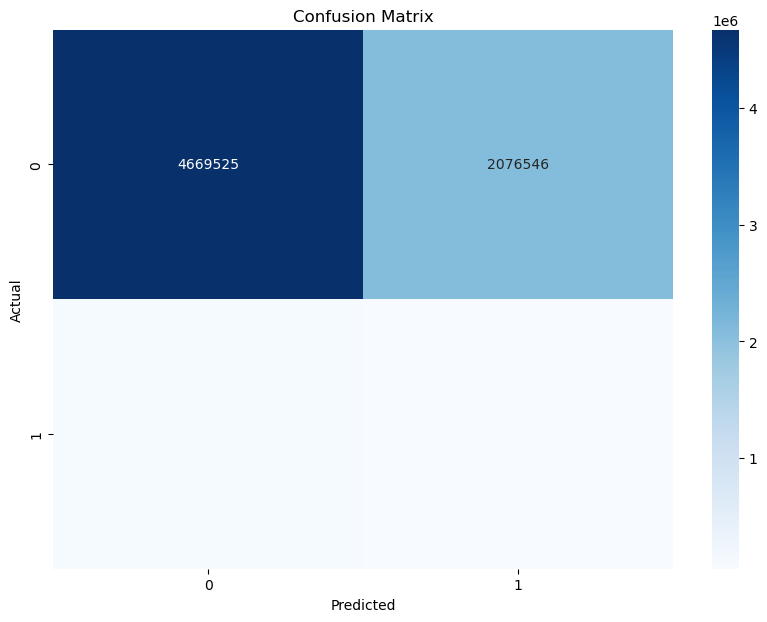

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set04 test02 unknown vehicle, known attack)

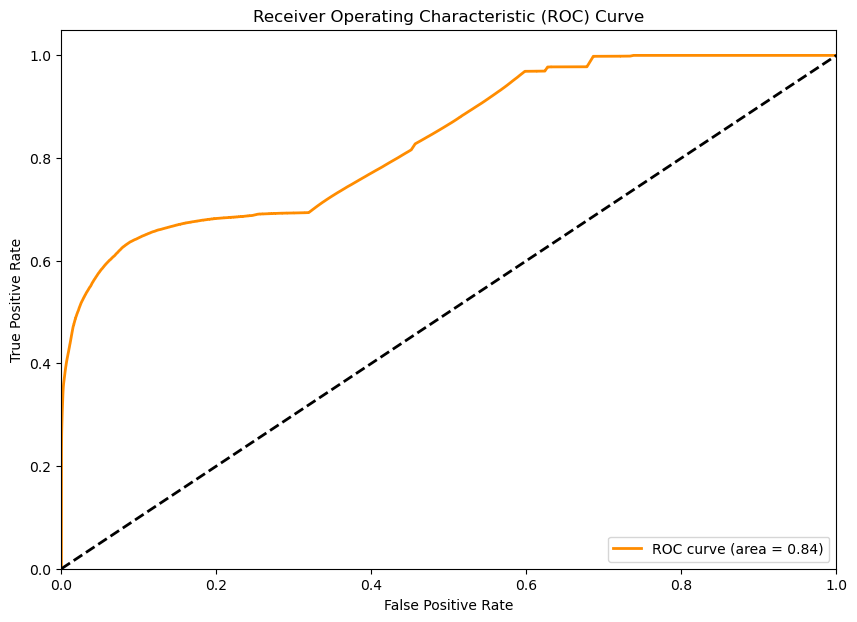

AUC: 0.8351
Accuracy: 0.8630
Precision: 0.9955
Recall: 0.8630
F1-score: 0.9234
Training Time: 14.5351 seconds
Testing Time: 1.5500 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93  17350855
           1       0.02      0.66      0.03     57239

    accuracy                           0.86  17408094
   macro avg       0.51      0.76      0.48  17408094
weighted avg       1.00      0.86      0.92  17408094



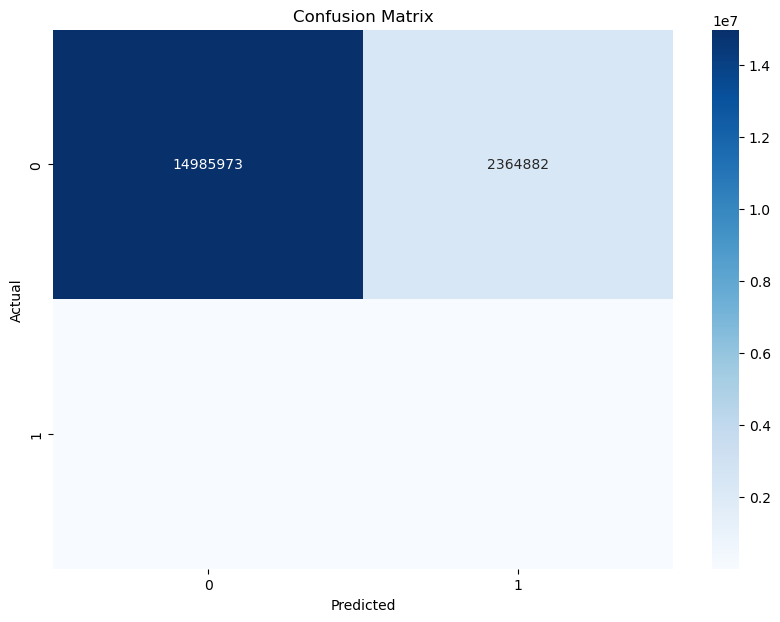

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set04 test03 known vehicle, unknown attack)

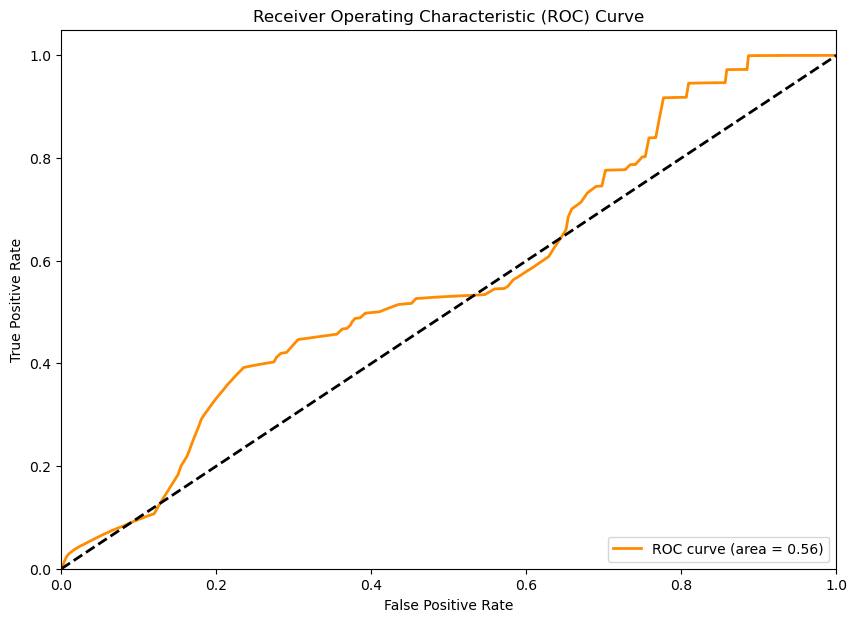

AUC: 0.5630
Accuracy: 0.7467
Precision: 0.9601
Recall: 0.7467
F1-score: 0.8356
Training Time: 14.1097 seconds
Testing Time: 0.6357 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85   6698045
           1       0.04      0.40      0.07    156189

    accuracy                           0.75   6854234
   macro avg       0.51      0.57      0.46   6854234
weighted avg       0.96      0.75      0.84   6854234



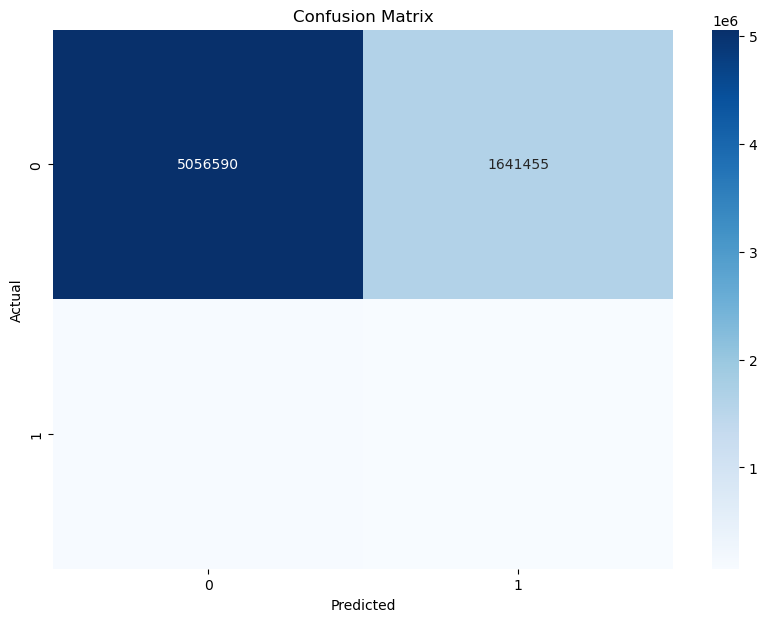

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set04 test04 unknown vehicle, unknown attack)

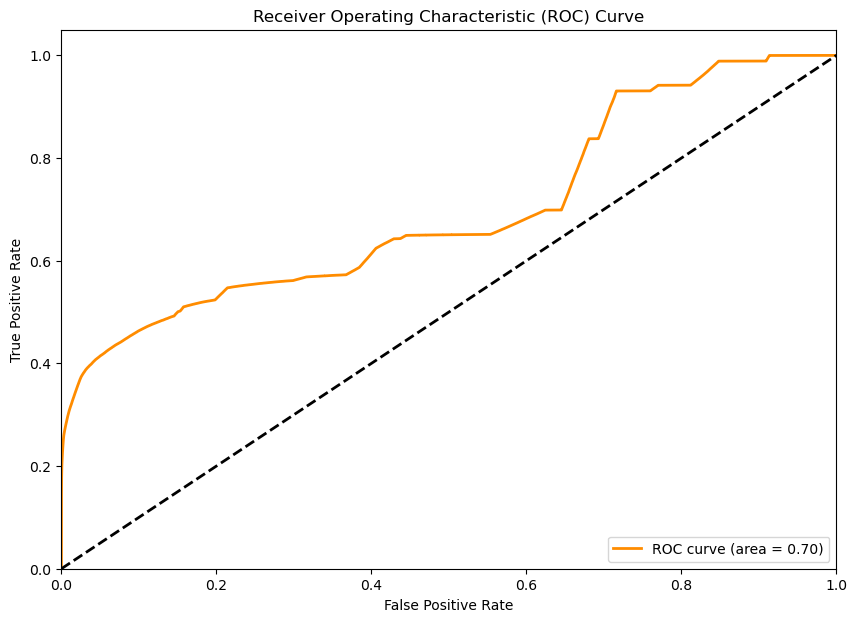

AUC: 0.6977
Accuracy: 0.7773
Precision: 0.9594
Recall: 0.7773
F1-score: 0.8522
Training Time: 13.9192 seconds
Testing Time: 1.3988 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87   7962655
           1       0.07      0.55      0.12    220971

    accuracy                           0.78   8183626
   macro avg       0.52      0.67      0.49   8183626
weighted avg       0.96      0.78      0.85   8183626



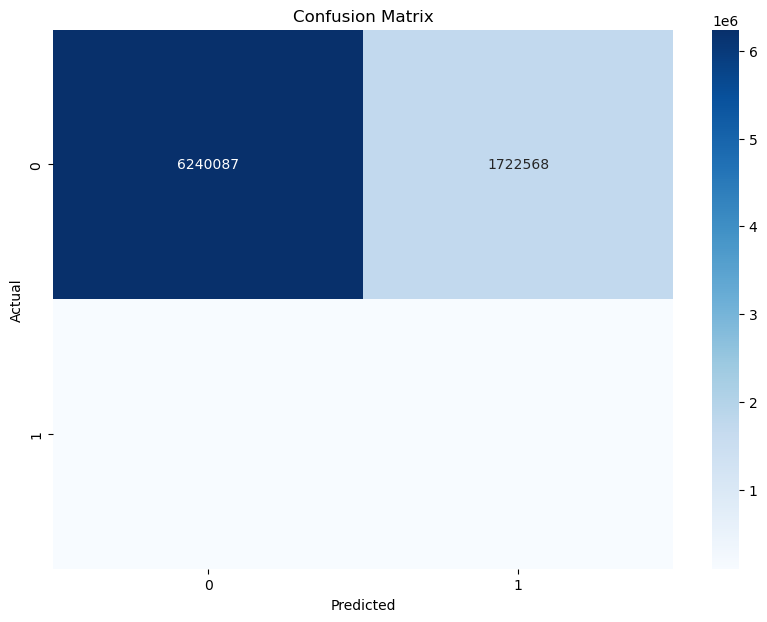

In [5]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set04 test 01 known vehicle, known attack)

Accuracy: 0.9787
Precision: 0.9755
Recall: 0.9787
F1-score: 0.9689
Training Time: 65.4520 seconds
Testing Time: 1012.2405 seconds


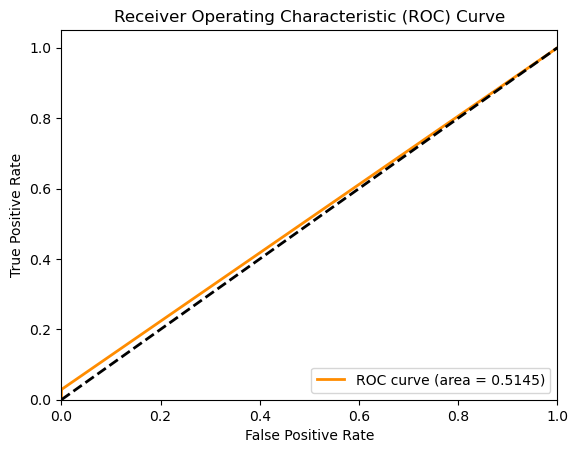

AUC: 0.5145


In [6]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set04 test 02 unknown vehicle, known attack)

Accuracy: 0.8997
Precision: 0.9937
Recall: 0.8997
F1-score: 0.9441
Training Time: 36.6808 seconds
Testing Time: 1864.3265 seconds


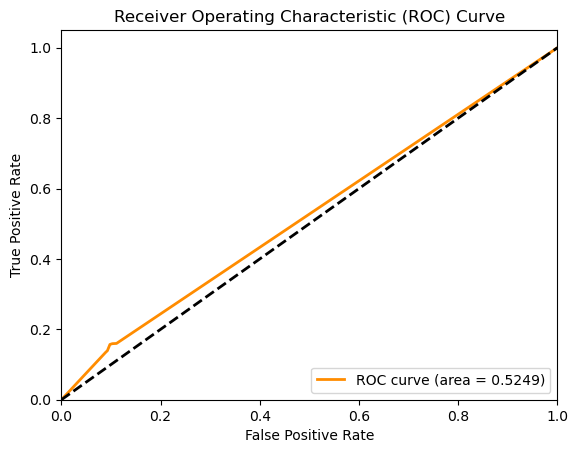

AUC: 0.5249


In [3]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set04 test 03 known vehicle, unknown attack)

Accuracy: 0.9794
Precision: 0.9783
Recall: 0.9794
F1-score: 0.9713
Training Time: 34.7190 seconds
Testing Time: 514.6652 seconds


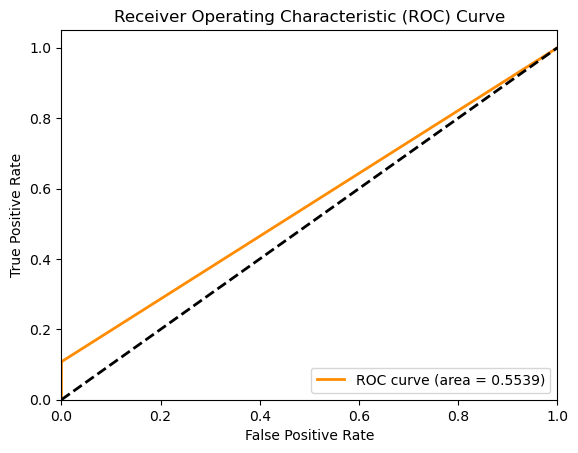

AUC: 0.5539


In [4]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set04 test 04 unknown vehicle, unknown attack)

Accuracy: 0.8387
Precision: 0.9477
Recall: 0.8387
F1-score: 0.8885
Training Time: 37.2965 seconds
Testing Time: 828.0997 seconds


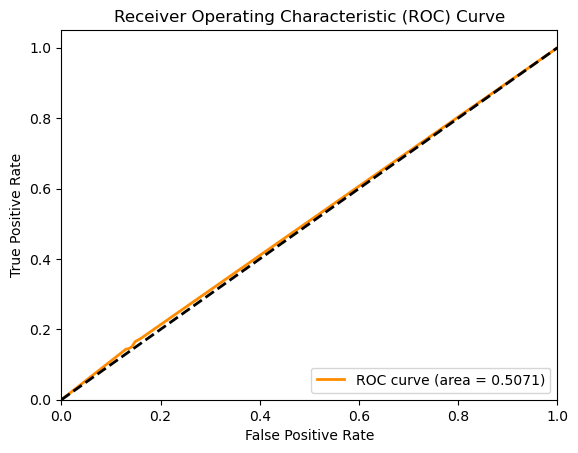

AUC: 0.5071


In [5]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set04 test 01 known vehicle, known attack)

Accuracy: 0.9781
Precision: 0.9573
Recall: 0.9781
F1-score: 0.9675
Training Time: 406.8818 seconds
Testing Time: 8.7902 seconds


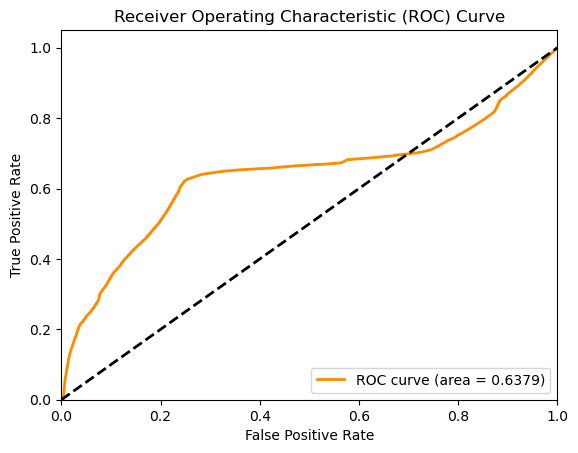

AUC: 0.6379


In [6]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set04 test 02 unknown vehicle, known attack)

Accuracy: 0.9959
Precision: 0.9934
Recall: 0.9959
F1-score: 0.9947
Training Time: 500.8717 seconds
Testing Time: 124.2389 seconds


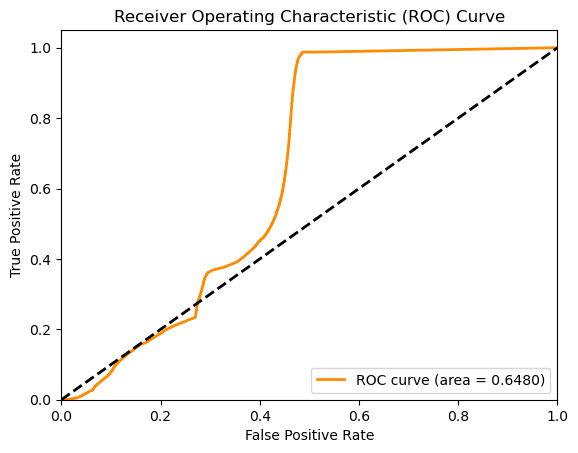

AUC: 0.6480


In [7]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set04 test 03 known vehicle, unknown attack)

Accuracy: 0.9773
Precision: 0.9705
Recall: 0.9773
F1-score: 0.9664
Training Time: 427.8619 seconds
Testing Time: 7.1315 seconds


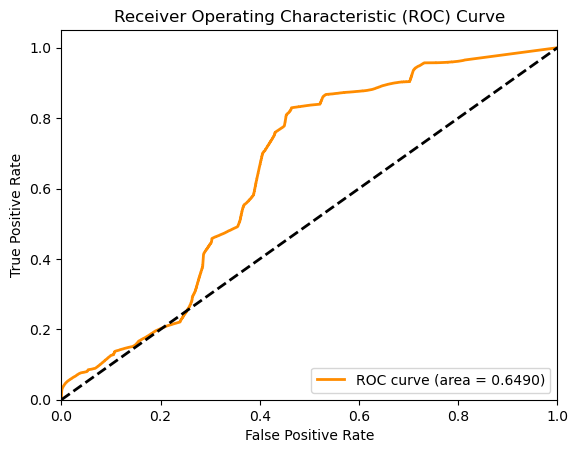

AUC: 0.6490


In [8]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set04 test 04 unknown vehicle, unknown attack)

Accuracy: 0.9675
Precision: 0.9467
Recall: 0.9675
F1-score: 0.9570
Training Time: 463.9580 seconds
Testing Time: 15.1927 seconds


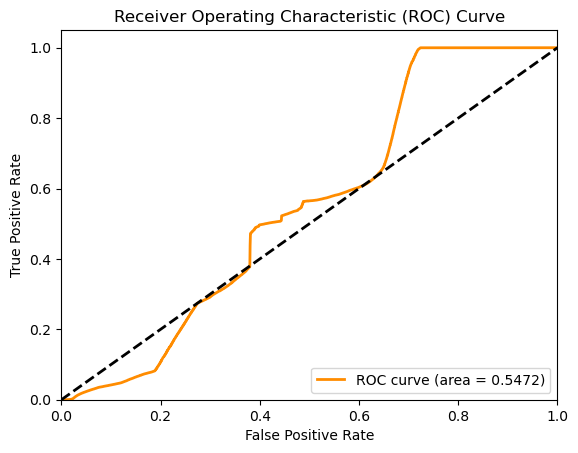

AUC: 0.5472


In [9]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set04 test 01 known vehicle, known attack)


Decision Tree Results
Accuracy: 0.9838
Precision: 0.9836
Recall: 0.9838
F1-score: 0.9792
Training Time: 49.5673 seconds
Testing Time: 1.3950 seconds


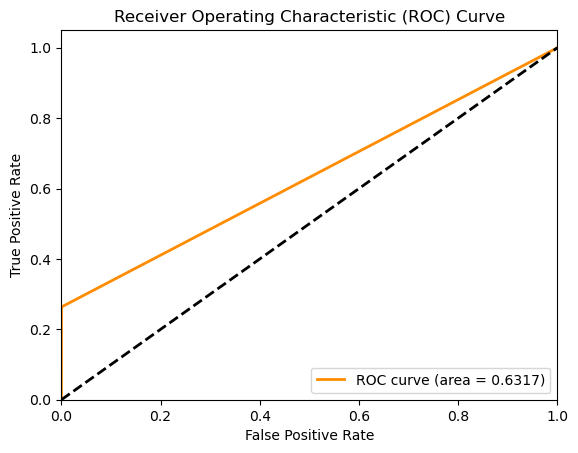

AUC: 0.6317


In [10]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set04 test 02 unknown vehicle, known attack)


Decision Tree Results
Accuracy: 0.9583
Precision: 0.9944
Recall: 0.9583
F1-score: 0.9756
Training Time: 38.3202 seconds
Testing Time: 4.1448 seconds


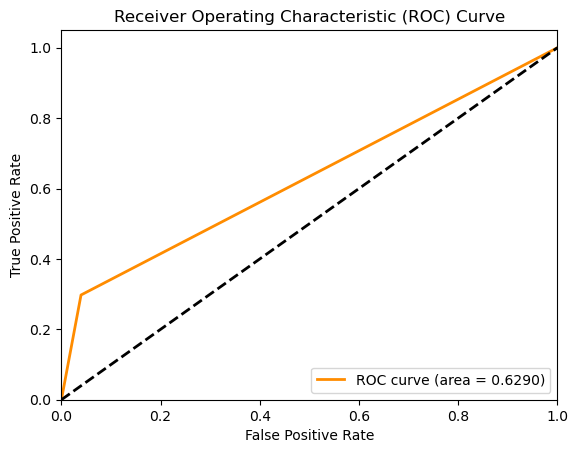

AUC: 0.6290


In [1]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set04 test 03 known vehicle, unknown attack)


Decision Tree Results
Accuracy: 0.9814
Precision: 0.9810
Recall: 0.9814
F1-score: 0.9752
Training Time: 42.9314 seconds
Testing Time: 1.5645 seconds


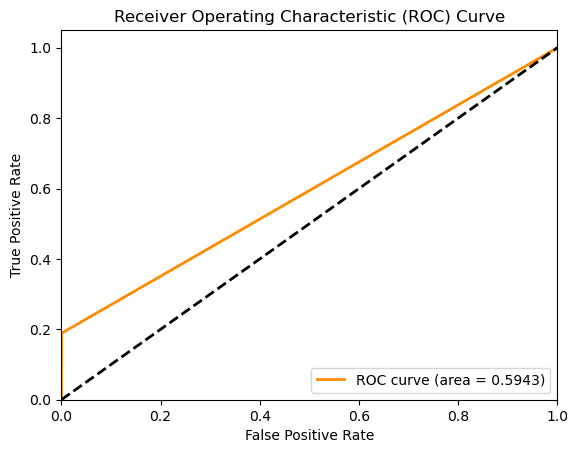

AUC: 0.5943


In [2]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set04 test 04 unknown vehicle, unknown attack)


Decision Tree Results
Accuracy: 0.9318
Precision: 0.9576
Recall: 0.9318
F1-score: 0.9437
Training Time: 36.1691 seconds
Testing Time: 1.9360 seconds


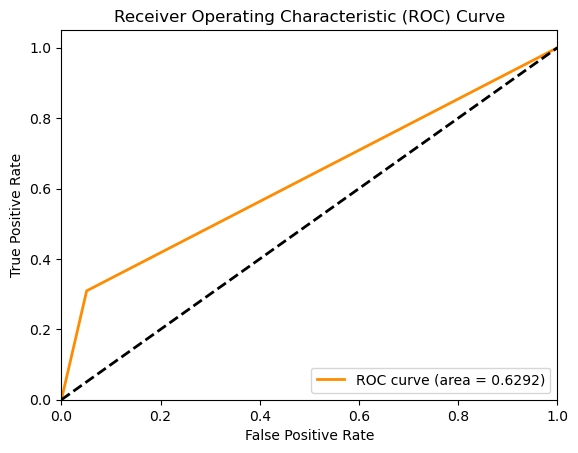

AUC: 0.6292


In [3]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set04 test01 known vehicle, known attack)

Accuracy: 0.9782
Precision: 0.9646
Recall: 0.9782
F1-score: 0.9675
ROC AUC: 0.5004
Training Time: 310.5665 seconds
Testing Time: 119.8730 seconds


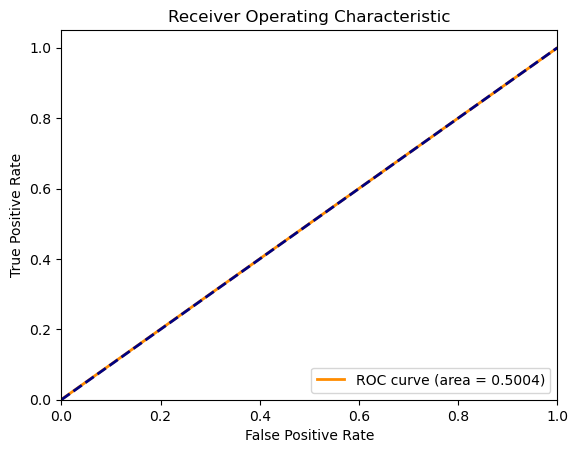

In [4]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.9806
Precision: 0.9937
Recall: 0.9806
F1-score: 0.9870
ROC AUC: 0.5295
Training Time: 348.6389 seconds
Testing Time: 170.5646 seconds


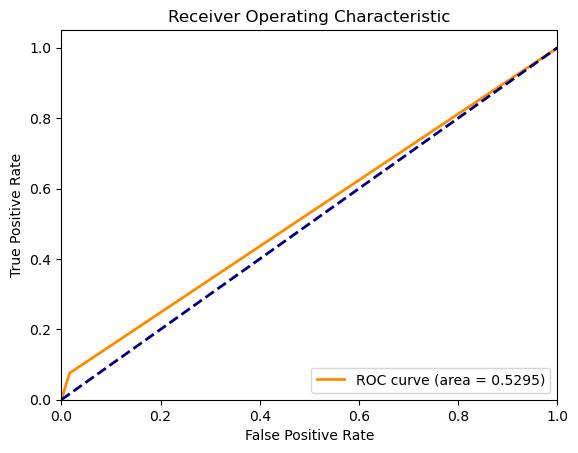

In [5]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.9787
Precision: 0.9788
Recall: 0.9787
F1-score: 0.9696
ROC AUC: 0.5339
Training Time: 323.6909 seconds
Testing Time: 129.3284 seconds


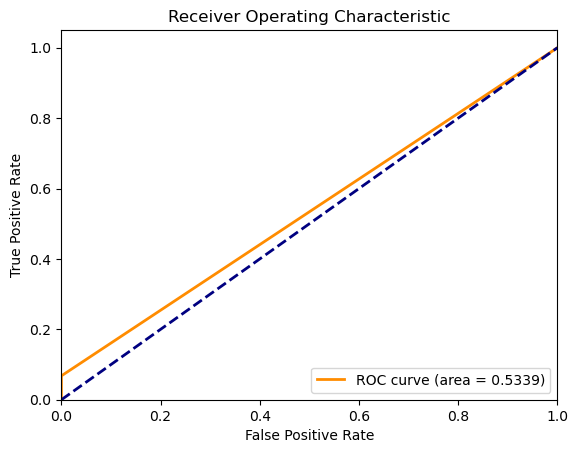

In [6]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.9712
Precision: 0.9560
Recall: 0.9712
F1-score: 0.9611
ROC AUC: 0.5233
Training Time: 269.6528 seconds
Testing Time: 104.9729 seconds


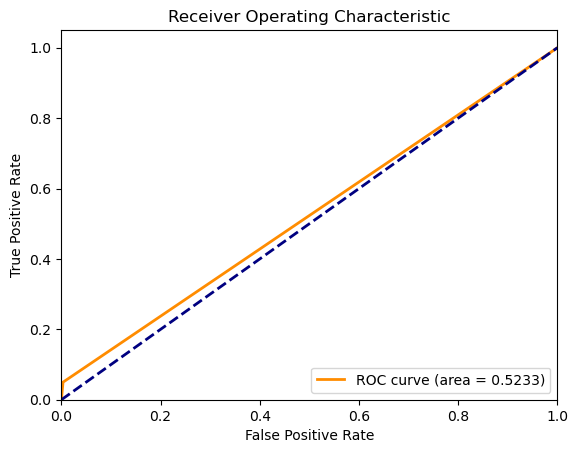

In [8]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_04\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
